# Model_6 : Transfert Learning based on Model_1 on top of MobileNetV2 with Fine-Tuning, Anti-Overfitting, 3-Way Split

## 1. Imports & Setup

In [1]:
# Load libraries and configuration for training.

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import kagglehub

## 2. Download Dataset

In [2]:
# Load the Animals-10 dataset from Kaggle using kagglehub.
#
# The dataset is structured as folders, one per class.

# Download dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)

# Dataset path and parameters
dataset_path = "/kaggle/input/animals10/raw-img"
IMG_SIZE = (160, 160)

Path to dataset files: /kaggle/input/animals10


## 3. Load & Preprocess Data
Convert the dataset into NumPy arrays and preprocess using MobileNetV2 pipeline.


In [3]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True
)

# Translate class names from Italian to English
class_names = dataset.class_names
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "ragno": "spider"
}
class_names = [translate.get(name, name) for name in class_names]
translated_class_names = [translate.get(name, name) for name in class_names]

# Convert tensors to NumPy
x, y = [], []
for img, label in dataset:
    x.append(img.numpy())
    y.append(label.numpy())

x = np.array(x)
y = np.array(y)

# Preprocess images
x = preprocess_input(x)

Found 26179 files belonging to 10 classes.


### 3-Way Split: Train (70%), Val (15%), Test (15%)

In [4]:
# 3-Way Split: Train (70%), Val (15%), Test (15%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", x_train.shape)
print("Validation:", x_val.shape)
print("Test:", x_test.shape)

Train: (18325, 160, 160, 3)
Validation: (3927, 160, 160, 3)
Test: (3927, 160, 160, 3)


## 4. Built Model with frozen based and fine tuning

In [5]:
# Model Definition
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = callbacks.ModelCheckpoint("./models/best_model_model6.keras", save_best_only=True)
earlystop_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Phase 1: Frozen base model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Phase 2: Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.7445 - loss: 0.8091 - val_accuracy: 0.9486 - val_loss: 0.1572
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9232 - loss: 0.2453 - val_accuracy: 0.9524 - val_loss: 0.1464
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9355 - loss: 0.2138 - val_accuracy: 0.9570 - val_loss: 0.1381
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9432 - loss: 0.1845 - val_accuracy: 0.9514 - val_loss: 0.1423
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9415 - loss: 0.1790 - val_accuracy: 0.9521 - val_loss: 0.1435
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9430 - loss: 0.1726 - val_accuracy: 0.9511 - val_loss: 0.1413
Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 53s 58ms/step - accuracy: 0.8672 - loss: 0.4281 - val_accuracy: 0.9580 - val_loss: 0.1345
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 1

## 8. Plot Accuracy & Loss

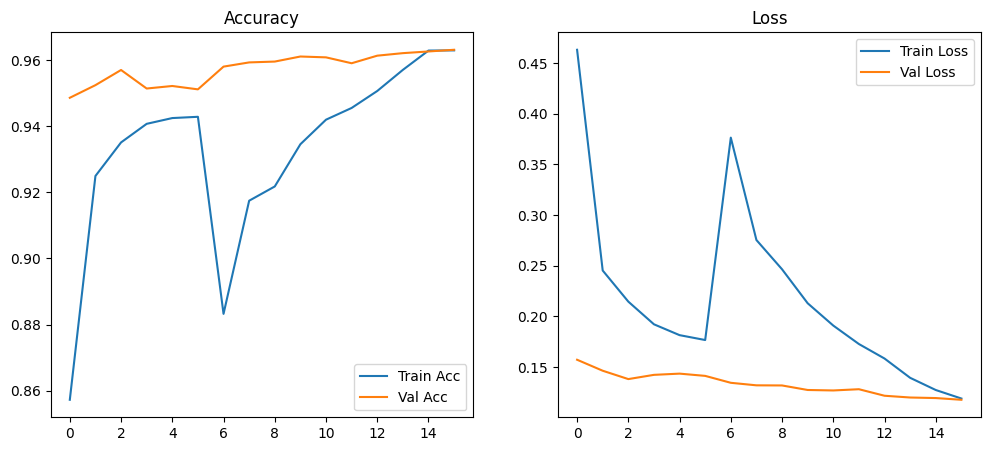

In [6]:
# Performance plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# 9. Evaluate on test set

123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step

Classification Report:
              precision    recall  f1-score   support

         dog       0.96      0.97      0.96       730
       horse       0.94      0.97      0.95       393
    elephant       0.99      0.94      0.96       217
   butterfly       0.97      0.98      0.98       317
     chicken       0.98      0.97      0.98       465
         cat       0.96      0.95      0.95       250
         cow       0.90      0.91      0.91       280
       sheep       0.96      0.90      0.93       273
      spider       0.98      0.99      0.98       723
    squirrel       0.97      0.99      0.98       279

    accuracy                           0.96      3927
   macro avg       0.96      0.96      0.96      3927
weighted avg       0.96      0.96      0.96      3927



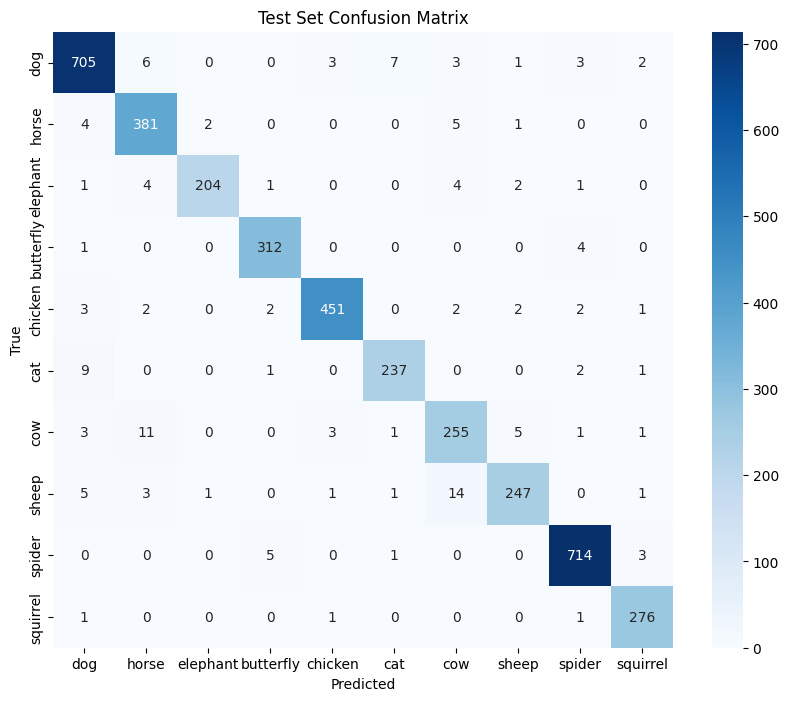

In [7]:
# Evaluation on test set
y_pred = np.argmax(model.predict(x_test), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=translated_class_names))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=translated_class_names, yticklabels=translated_class_names)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 10. Save Predictions (optional)

In [8]:
# Save test set predictions to CSV
prediction_df = pd.DataFrame({
    "True Label": [translated_class_names[i] for i in y_test],
    "Predicted Label": [translated_class_names[i] for i in y_pred]
})
prediction_df.to_csv("test_predictions_model6.csv", index=False)
print("✅ Saved test predictions to test_predictions_model6.csv")


✅ Saved test predictions to test_predictions_model6.csv


## 11. Final Metrics Summary

In [9]:
# Final Metrics Summary
model.summary()
loss, acc = model.evaluate(x_test, y_test)
print("\n📉 Test Loss:", loss)
print("📊 Test Accuracy (from model.evaluate):", acc)
print("📊 Test Accuracy (from sklearn):", accuracy_score(y_test, y_pred))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,228,768 (23.76 MB)

 Trainable params: 1,944,074 (7.42 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,888,150 (14.83 MB)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9644 - loss: 0.1305

📉 Test Loss: 0.1319255381822586
📊 Test Accuracy (from model.evaluate): 0.963076114654541
📊 Test Accuracy (from sklearn): 0.9630761395467278


## 12. Model prediction on random animal image for the net
Download the image (specific to google colab)

In [21]:
from google.colab import files
uploaded = files.upload()


Saving horse_1.jpg to horse_1.jpg


Preprocessing the image

In [22]:
from PIL import Image
import numpy as np

def preprocess_image_from_path(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

Predict the result

In [24]:

img_array = preprocess_image_from_path('horse_1.jpg')
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)[0]
print("Predicted class:", class_names[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: horse
